In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
import cv2
import tensorflow as tf
from tqdm import tqdm  #in forloop such as progressbar



In [28]:
class_names=['CaS','CoS','Gum','MC','OC','OLP','OT']
class_names_label={class_name:i for i,class_name in enumerate(class_names)}
nb_classes=len(class_names)
image_size=(150,150)
print(class_names_label)

{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}


In [29]:
def load_data():
  datasets=['/content/drive/MyDrive/Teeth DataSet (1)/Teeth_Dataset/Training','/content/drive/MyDrive/Teeth DataSet (1)/Teeth_Dataset/Validation','/content/drive/MyDrive/Teeth DataSet (1)/Teeth_Dataset/Testing']
  output=[]
  for dataset in datasets:
    images=[]
    labels=[]
    print('Loading {}'.format(dataset))
    for folder in os.listdir(dataset):
      folder_path = os.path.join(dataset, folder)
      if os.path.isdir(folder_path) and folder in class_names_label:
          label = class_names_label[folder]
          for file in tqdm(os.listdir(folder_path)):
              img_path = os.path.join(folder_path, file)
              img = cv2.imread(img_path)
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
              img = cv2.resize(img, image_size)
              images.append(img)
              labels.append(label)

    images=np.array(images,dtype='float32')
    labels=np.array(labels,dtype='int32')
    output.append((images,labels))

  return output

In [30]:
(train_images,train_labels),(val_images,val_labels),(test_images,test_labels)=load_data()

Loading /content/drive/MyDrive/Teeth DataSet (1)/Teeth_Dataset/Training


100%|██████████| 540/540 [00:05<00:00, 95.19it/s] 


Loading /content/drive/MyDrive/Teeth DataSet (1)/Teeth_Dataset/Validation


100%|██████████| 108/108 [00:00<00:00, 120.43it/s]


Loading /content/drive/MyDrive/Teeth DataSet (1)/Teeth_Dataset/Testing


100%|██████████| 149/149 [00:01<00:00, 126.83it/s]


In [31]:
n_train =train_labels.shape[0]
n_val=val_labels.shape[0]
n_test=test_labels.shape[0]

print("Number of training examples: {}".format(n_train))
print("Number of validation examples: {}".format(n_val))
print("Number of testing examples: {}".format(n_test))

Number of training examples: 3780
Number of validation examples: 1028
Number of testing examples: 1028


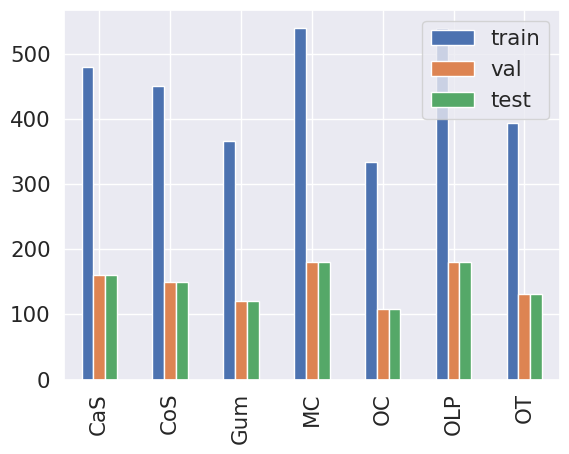

In [7]:
import pandas as pd
_,train_counts=np.unique(train_labels,return_counts=True)
_,val_counts=np.unique(val_labels,return_counts=True)
_,test_counts=np.unique(test_labels,return_counts=True)
pd.DataFrame({'train':train_counts,'val':val_counts,'test':test_counts},index=class_names).plot(kind='bar')
plt.show()

Data Augmentation

we will use data augmentaion to increase photoes in less classes

we will make photo in all 6 classes are equal

In [14]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import numpy as np

train_dir = '/content/drive/MyDrive/Teeth DataSet (1)/Teeth_Dataset/Training'

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2]
)


#to count numper of photo in all classes
class_counts = {}
for folder in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder)
    if os.path.isdir(folder_path):
        class_counts[folder] = len(os.listdir(folder_path))


target_count = class_counts['MC']


print("numper of photoes befor edit:")
for k, v in class_counts.items():
    print(f"{k}: {v}")


for class_name, count in class_counts.items():
    if count < target_count:
        class_path = os.path.join(train_dir, class_name)
        images = os.listdir(class_path)
        i = 0
        current_count = count

        while current_count < target_count:
            img_path = os.path.join(class_path, images[i % len(images)])
            img = load_img(img_path)
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)

            aug_iter = datagen.flow(x, batch_size=1)
            aug_image = next(aug_iter)[0].astype('uint8')

            new_image_name = f"aug_{current_count}.jpg"
            save_path = os.path.join(class_path, new_image_name)
            array_to_img(aug_image).save(save_path)

            current_count += 1
            i += 1

print("\n done ✅")

numper of photoes befor edit:
OLP: 540
OT: 393
OC: 334
CaS: 480
Gum: 366
MC: 540
CoS: 450

 done ✅


In [16]:
for folder in os.listdir(train_dir):
    print(folder, ":", len(os.listdir(os.path.join(train_dir, folder))))

OLP : 540
OT : 540
OC : 540
CaS : 540
Gum : 540
MC : 540
CoS : 540


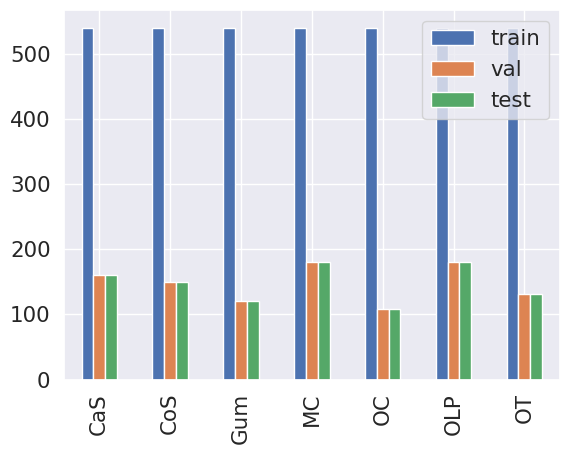

In [32]:
import pandas as pd
_,train_counts=np.unique(train_labels,return_counts=True)
_,val_counts=np.unique(val_labels,return_counts=True)
_,test_counts=np.unique(test_labels,return_counts=True)
pd.DataFrame({'train':train_counts,'val':val_counts,'test':test_counts},index=class_names).plot(kind='bar')
plt.show()

Normalization

In [33]:
train_images=train_images/255
val_images=val_images/255
test_images=test_images/255

In [34]:
def display_random_images_and_labels(class_names,images,labels):
  index=np.random.randint(images.shape[0])
  plt.figure()
  plt.imshow(images[index])
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.title('Image #{} : {}'.format(index,class_names[labels[index]]))
  plt.show()

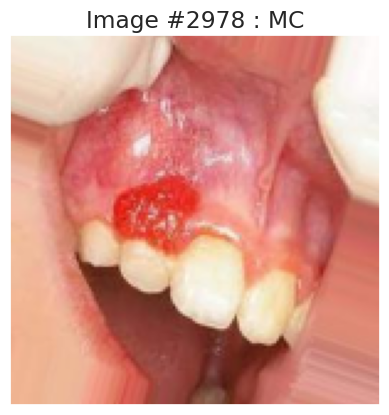

In [35]:
display_random_images_and_labels(class_names,train_images,train_labels)

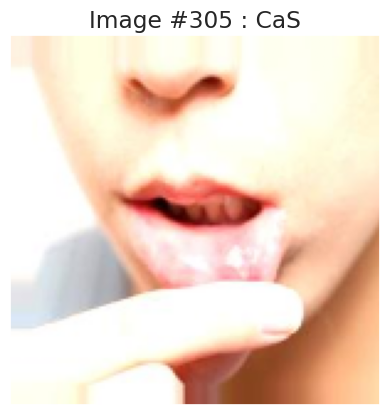

In [36]:
display_random_images_and_labels(class_names,val_images,val_labels)

In [37]:
def display_examples(class_names,labels):
  fig=plt.figure(figsize=(10,10))
  fig.suptitle("Examples of images of each class")
  for i in range(25):
    ax=plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    index=np.random.randint(labels.shape[0])
    plt.imshow(train_images[index])
    plt.xlabel(class_names[labels[index]])
  plt.show()

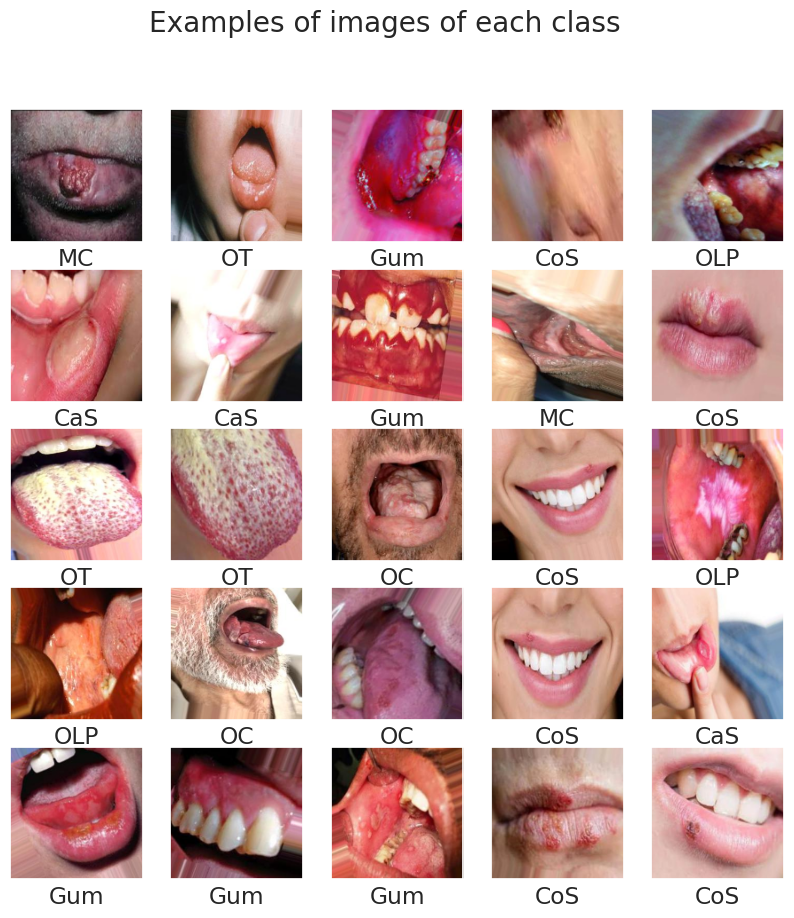

In [38]:
display_examples(class_names,train_labels)

In [39]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(nb_classes,activation='softmax') # Corrected output units
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [41]:
history=model.fit(train_images,train_labels,batch_size=50,epochs=10,validation_data=(val_images,val_labels))

Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.2066 - loss: 1.9603 - val_accuracy: 0.2938 - val_loss: 1.7731
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.3934 - loss: 1.5921 - val_accuracy: 0.4086 - val_loss: 1.5226
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.5286 - loss: 1.2725 - val_accuracy: 0.5331 - val_loss: 1.2564
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6605 - loss: 0.9835 - val_accuracy: 0.5564 - val_loss: 1.2143
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.7708 - loss: 0.6736 - val_accuracy: 0.5457 - val_loss: 1.2744
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8199 - loss: 0.5360 - val_accuracy: 0.5973 - val_loss: 1.2139
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9149 - loss: 0.2908 - val_accuracy: 0.5730 - val_loss: 1.4353
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9433 - loss: 0.1934 - val_accuracy: 0.6265 - v

In [42]:
test_images

array([[[[0.6784314 , 0.5803922 , 0.6       ],
         [0.6784314 , 0.5764706 , 0.5921569 ],
         [0.67058825, 0.57254905, 0.5803922 ],
         ...,
         [0.7490196 , 0.4509804 , 0.42745098],
         [0.7529412 , 0.44313726, 0.42352942],
         [0.7490196 , 0.43137255, 0.41568628]],

        [[0.7019608 , 0.6117647 , 0.6392157 ],
         [0.69411767, 0.6039216 , 0.627451  ],
         [0.6862745 , 0.6       , 0.6156863 ],
         ...,
         [0.7372549 , 0.4392157 , 0.41960785],
         [0.7411765 , 0.43137255, 0.4117647 ],
         [0.74509805, 0.42745098, 0.4117647 ]],

        [[0.72156864, 0.6392157 , 0.6784314 ],
         [0.7176471 , 0.63529414, 0.67058825],
         [0.70980394, 0.627451  , 0.65882355],
         ...,
         [0.75686276, 0.45490196, 0.43137255],
         [0.7529412 , 0.4392157 , 0.42352942],
         [0.7411765 , 0.41960785, 0.40392157]],

        ...,

        [[0.7607843 , 0.46666667, 0.38431373],
         [0.73333335, 0.4509804 , 0.3647059 ]

In [49]:
y_pred=model.predict(test_images)

33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 282ms/step


In [44]:
from tensorflow.keras.preprocessing import image
img=image.load_img('/content/drive/MyDrive/Teeth DataSet (1)/Teeth_Dataset/Testing/output_image.jpg',target_size=(150,150))

In [48]:
img_array=image.img_to_array(img)
img_array=np.expand_dims(img_array,axis=0)
img_array=img_array/255.0


In [47]:
prediction=model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [46]:
class_names=['CaS','CoS','Gum','MC','OC','OLP','OT']
predict_class=class_names[np.argmax(prediction)]
predict_class

NameError: name 'prediction' is not defined